In [18]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_color_value,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge,
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    find_node_equ,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
    get_distance,
)
from amftrack.util.sys import (
    get_analysis_folders,
    get_time_plate_info_from_analysis,
    get_time_hypha_info_from_analysis,
    get_global_hypha_info_from_analysis,
)

from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import networkx as nx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def compute_ratio(G, pos, node1, node2):
    # Calculate the shortest path length
    shortest_path_length = nx.shortest_path_length(G, node1, node2, weight='length')

    # Calculate the Euclidean distance between node positions
    node1_pos = pos[node1]
    node2_pos = pos[node2]
    distance = np.sqrt((node1_pos[0] - node2_pos[0]) ** 2 + (node1_pos[1] - node2_pos[1]) ** 2)*1.725

    # Compute the ratio
    ratio = distance / shortest_path_length

    return ratio

def compute_global_efficiency(G, pos):
    total_ratio = 0
    count = 0
    all_pairs = nx.all_pairs_dijkstra_path_length(G, weight='length')
    # Iterate over all pairs of nodes
    for node1,distances in all_pairs:
        for node2 in distances.keys():
            if node1 != node2:
                node1_pos = pos[node1]
                node2_pos = pos[node2]
                shortest_path_length = distances[node2]
                distance = np.sqrt((node1_pos[0] - node2_pos[0]) ** 2 + (node1_pos[1] - node2_pos[1]) ** 2)*1.725

                    # Compute the ratio
                ratio = distance / shortest_path_length
                # Accumulate the ratio and increment the count
                total_ratio += ratio
                count += 1
            if count%1e6==0:
                print(count)
    # Compute the average ratio
        # break
    average_ratio = total_ratio / count

    return average_ratio

def get_crossingness(node,t):
    pairs = []
    can_be_removed = True

    for edge in node.edges(t):
        mini = np.inf
        for edge_candidate in node.edges(t):
            angle = np.cos(
                (
                    edge.orientation_begin(t, 100)
                    - edge_candidate.orientation_begin(t, 100)
                )
                / 360
                * 2
                * np.pi
            )
            if angle < mini:
                winner = edge_candidate
                mini = angle
        if (edge, winner) not in pairs and (
            winner,
            edge,
        ) not in pairs:
            pairs.append((edge, winner,mini))
    crossingness = np.min([-pair[2] for pair in pairs])
    pairs = [(pair[0],pair[1]) for pair in pairs]
    symetric = np.all([(pair[1],pair[0]) in pairs for pair in pairs])
    return(crossingness,symetric)

def treat_node(G,node):
    pairs = []
    
    for edge in node.edges(t):
        mini = np.inf
        for edge_candidate in node.edges(t):
            angle = np.cos(
                (
                    edge.orientation_begin(t, 100)
                    - edge_candidate.orientation_begin(t, 100)
                )
                / 360
                * 2
                * np.pi
            )
            if angle < mini:
                winner = edge_candidate
                mini = angle
        if (edge, winner) not in pairs and (
            winner,
            edge,
        ) not in pairs:
            pairs.append((edge, winner))
    can_be_removed = True
    # for pair in pairs:
    #     can_be_removed *= (
    #         pair[0].end.degree(t) != 1 or pair[1].end.degree(t) != 1
    #     )
    #     can_be_removed *= (
    #         pair[0].end.label not in articulation_points
    #         or pair[1].end.label not in articulation_points
    #     )
    if can_be_removed:
        for pair in pairs:
            right_n = pair[0].end
            left_n = pair[1].end
            right_edge = pair[0].pixel_list(t)
            left_edge = list(reversed(pair[1].pixel_list(t)))
            right_edge_width = pair[0].width(t)
            left_edge_width = pair[1].width(t)
            right_edge_length = pair[0].length_um(t)
            left_edge_length= pair[1].length_um(t)
            pixel_list = left_edge + right_edge[1:]
            info = {
                "weight": len(pixel_list),
                "pixel_list": pixel_list,
                "width": (
                    (len(right_edge) * right_edge_width)
                    + (len(left_edge) * left_edge_width)
                )
                / (left_edge_width + right_edge_width),
                "length" : right_edge_length + left_edge_length
            }
            if right_n != left_n:
                G.add_edges_from(
                    [(left_n.label, right_n.label, info)]
                )

        G.remove_node(node.label)

In [4]:
directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)
folders = all_folders.loc[all_folders['unique_id']=='94_20201123']
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled.p"] == True]

analysed:   0%|          | 0/3670 [00:00<?, ?it/s]

In [6]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 45
exp.load(folders.iloc[i:i+1],suffix="_labeled")
for t in range(exp.ts):
    exp.load_tile_information(t)
t = 0
nodes = get_all_nodes(exp, t)
nodes = [node for node in nodes if node.degree(t)>0]
high_degree_nodes = [node for node in nodes if node.degree(t)==4]
articulation_points = list(nx.articulation_points(exp.nx_graph[t]))
edges = get_all_edges(exp,t)
weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
crossingnesses = [get_crossingness(node,t)[0] for node in high_degree_nodes]
symetrics = [get_crossingness(node,t)[1] for node in high_degree_nodes]
crossing_nodes = [node for node in high_degree_nodes if get_crossingness(node,t)[1] and get_crossingness(node,t)[0]>=0.85]
crossing_nodes_label = [node.label for node in crossing_nodes]
G = exp.nx_graph[t]
components = nx.connected_components(G)

# Find the largest connected component
largest_component = max(components, key=len)

# Create a new graph representing the largest connected component
largest_component_graph = G.subgraph(largest_component)
largest_component_graph_no_cross = largest_component_graph.copy()
for node in crossing_nodes:
    if node.label in largest_component_graph_no_cross:
        treat_node(largest_component_graph_no_cross,node)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-25 10:02:00


In [12]:
def global_eff(k):
    i = k
    exp.load(folders.iloc[i:i+1],suffix="_labeled")
    for t in range(exp.ts):
        exp.load_tile_information(t)
    t = 0
    edges = get_all_edges(exp,t)
    weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
    nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    return(compute_global_efficiency(largest_component_graph, exp.positions[t]))

In [24]:
def global_eff_corrected(k):
    i = k
    exp.load(folders.iloc[i:i+1],suffix="_labeled")
    for t in range(exp.ts):
        exp.load_tile_information(t)
    t = 0
    nodes = get_all_nodes(exp, t)
    nodes = [node for node in nodes if node.degree(t)>0]
    high_degree_nodes = [node for node in nodes if node.degree(t)==4]
    articulation_points = list(nx.articulation_points(exp.nx_graph[t]))
    edges = get_all_edges(exp,t)
    weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
    nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
    crossingnesses = [get_crossingness(node,t)[0] for node in high_degree_nodes]
    symetrics = [get_crossingness(node,t)[1] for node in high_degree_nodes]
    crossing_nodes = [node for node in high_degree_nodes if get_crossingness(node,t)[1] and get_crossingness(node,t)[0]>=0.85]
    crossing_nodes_label = [node.label for node in crossing_nodes]
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    largest_component_graph_no_cross = largest_component_graph.copy()
    for node in crossing_nodes:
        if node.label in largest_component_graph_no_cross:
            treat_node(largest_component_graph_no_cross,node)
    return(compute_global_efficiency(largest_component_graph_no_cross, exp.positions[t]))

In [17]:
def global_eff_MS(k):
    i = k
    exp.load(folders.iloc[i:i+1],suffix="_labeled")
    for t in range(exp.ts):
        exp.load_tile_information(t)
    t = 0
    edges = get_all_edges(exp,t)
    weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
    nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    MS = nx.minimum_spanning_tree(largest_component_graph)
    return(compute_global_efficiency(MS, exp.positions[t]))

In [15]:
efficiencies = [global_eff(10*k) for k in range(10)]

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-23 12:53:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-23 23:00:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-24 09:01:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-24 19:02:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-25 05:02:00
0
1000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-25 15:02:00
0
1000000
2000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 01:02:00
0
1000000
2000000
3000000
4000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 11:02:00
0
1000000
2000000
3000000
4000000
5000000
6000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 21:09:00
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-27 07:09:00
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
9000000
10000000
11000000
12000000


In [25]:
efficiencies_corrected = [global_eff_corrected(10*k) for k in range(10)]

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-23 12:53:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-23 23:00:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-24 09:01:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-24 19:02:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-25 05:02:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-25 15:02:00
0
1000000
2000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 01:02:00
0
1000000
2000000
3000000
4000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 11:02:00
0
1000000
2000000
3000000
4000000
5000000
6000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 21:09:00
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-27 07:09:00
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000


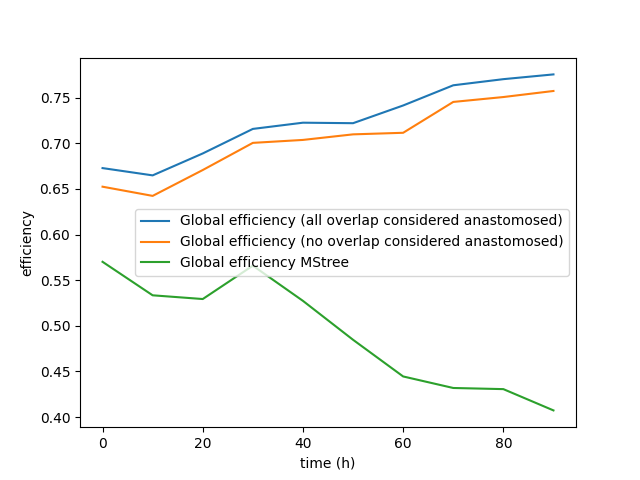

In [28]:
fig,ax = plt.subplots()
time = [10*k for k in range(10)]
ax.plot(time,efficiencies,label ="Global efficiency (all overlap considered anastomosed)")
ax.plot(time,efficiencies_corrected,label ="Global efficiency (no overlap considered anastomosed)")

ax.plot(time,efficienciesMS,label ="Global efficiency MStree")
ax.set_xlabel("time (h)")
ax.set_ylabel("efficiency")

ax.legend()

In [19]:
efficienciesMS = [global_eff_MS(10*k) for k in range(10)]

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-23 12:53:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-23 23:00:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-24 09:01:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-24 19:02:00
0


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-25 05:02:00
0
1000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-25 15:02:00
0
1000000
2000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 01:02:00
0
1000000
2000000
3000000
4000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 11:02:00
0
1000000
2000000
3000000
4000000
5000000
6000000


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2020-11-26 21:09:00
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
2020-11-27 07:09:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
9000000
10000000
11000000
12000000


In [20]:
efficienciesMS

[0.5701333160058668,
 0.5334182589302037,
 0.5293376275847033,
 0.5659122116037855,
 0.5273215615624443,
 0.4846615016927764,
 0.4444674991559014,
 0.4318284790298444,
 0.43057991519243044,
 0.4072560955764963]